In [569]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [570]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,1,0,0,0,0,98166,47.4697,-122.351
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [571]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I',
       'zipcode', 'lat', 'long'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [572]:
clean_continuous = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'age']]

In [573]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

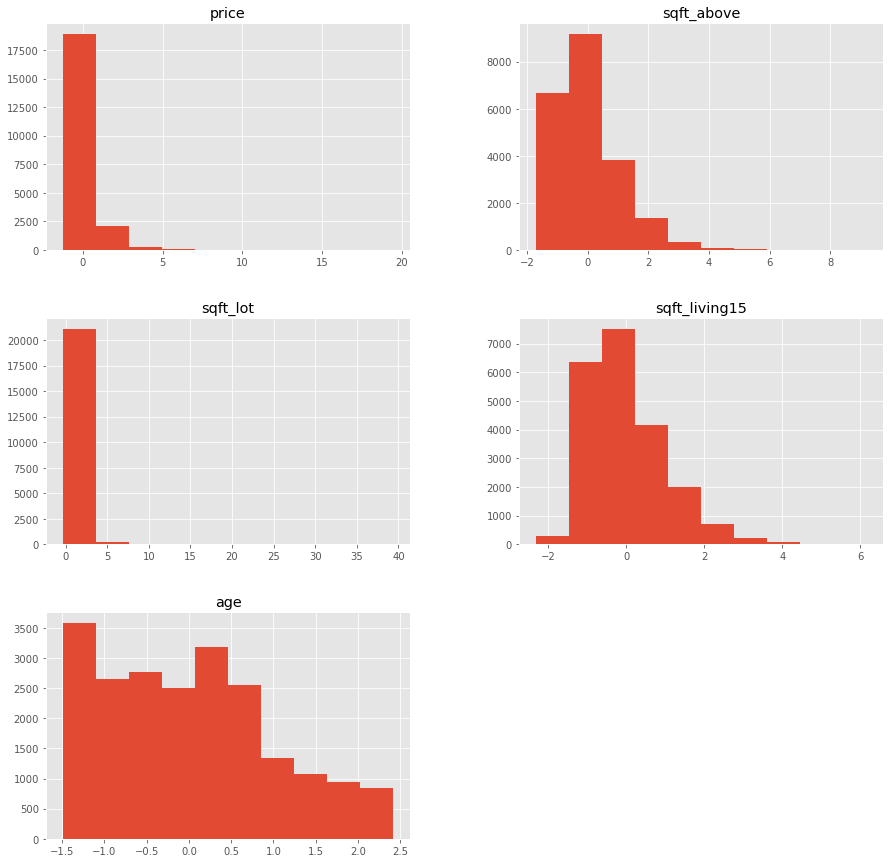

In [574]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [575]:
clean.drop(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'age'], axis = 1, inplace = True)

In [576]:
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [577]:
clean.head()

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_H,zip_I,zipcode,lat,long,price,sqft_above,sqft_lot,sqft_living15,age
15937,12.502281,6.779922,8.999619,6.907755,8100,3,1.00,1.0,0,1,...,0,0,98166,47.4697,-122.351,-0.740571,-1.099527,-0.169225,-1.441766,0.955962
20963,12.898970,6.802395,6.912743,7.272398,1188,2,1.75,1.5,0,1,...,0,0,98027,47.5446,-122.018,-0.384457,-1.075393,-0.340062,-0.799934,-1.357975
7614,12.733755,6.579251,8.325548,7.319865,4538,3,1.00,1.0,0,1,...,0,0,98126,47.5296,-122.379,-0.550073,-1.292602,-0.264865,-0.697824,0.989991
3257,12.847927,6.733402,8.905444,7.565275,5150,2,1.00,1.0,0,1,...,0,0,98126,47.5285,-122.378,-0.438575,-1.147796,-0.186754,-0.085165,1.092076
16723,12.807653,7.377759,8.335192,7.081709,4168,5,2.00,1.5,0,0,...,0,0,98126,47.5297,-122.381,-0.479367,-0.230689,-0.263901,-1.164611,1.500418


# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [578]:
#including all non-log-transformed features without neighborhood information
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

With the linear regression, you would interpret log transformed variables as a percentage change. Here’s a quick breakdown: (http://data-slinky.com/2016/09/06/log_trans.html)

* If your response variable, y, is log-transformed and assuming you have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If your predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [579]:
preprocessed_A.shape

(21420, 24)

In [580]:
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

## Perform Stepwise Selection

In [581]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [582]:
#apply function
result = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  base_1.0                       with p-value 8.75145e-194
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floors        

In [583]:
#check out how many features satisfy p < 0.05
len(result)

19

## Build Model in Statsmodels

In [584]:
#build initial model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:04:45   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
age               0.1431      0.006     23.120      0.000       0.131       0.155
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* We have a JB value = ~978, which is very high and not in favor of normality. 
* p-value of 0 which rejects the null hypothesis for normality. 
* Additionally, the kurtosis is ~4, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. 
* The skewness value of 0.17 shows that underlying data is symmetrical. 

In [585]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result], y)

#predict yhat using our model
yhat = linreg.predict(X[result])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

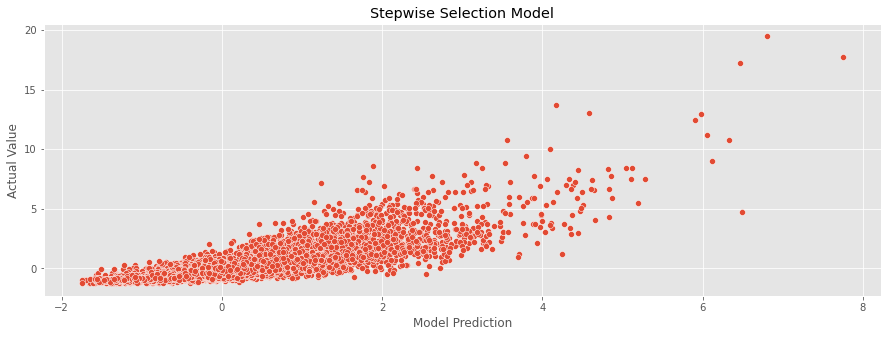

In [586]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.scatterplot(yhat, y)
plt.title('Stepwise Selection Model')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_A_scatterplot')

In [587]:
#get intercept
linreg.intercept_

-0.550135539414703

In [588]:
#get coefficients and sort them
coefficients = dict(zip(X, list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'zip_E': -0.13523211025571102,
 'base_1.0': -0.11066913362648448,
 'cond_2.0': -0.08210151123051114,
 'cond_3.0': -0.07800378763802446,
 'zip_D': -0.05685379780858932,
 'zip_C': 0.08376544156919963,
 'zip_A': 0.13896434716421513,
 'sqft_lot': 0.14314370392407563,
 'zip_B': 0.1622067074399149,
 'age': 0.1772066572624469,
 'cond_5.0': 0.17982888317665546,
 'sqft_above': 0.2142324014310087,
 'floors': 0.3292482733084542,
 'reno_1.0': 0.34465306006076746,
 'water_1.0': 0.474835108905516,
 'bathrooms': 0.5372882770934375,
 'bedrooms': 0.7337234937057018,
 'sqft_lot15': 0.7858900555592199,
 'sqft_living15': 2.314977026777242}

**Recheck for multicollinearity**

In [589]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_A[result]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(result, vif))

[('bathrooms', 24.5808924376999),
 ('age', 2.2423648207258178),
 ('water_1.0', 1.0400373391710502),
 ('zip_C', 1.8249194859859676),
 ('sqft_living15', 2.6318276577199327),
 ('zip_A', 4.290652617544419),
 ('sqft_above', 3.148057722816477),
 ('base_1.0', 2.7822492090783775),
 ('zip_B', 1.8220859772868632),
 ('bedrooms', 17.341313318594572),
 ('zip_G', 1.5956441254772722),
 ('zip_F', 1.459053857213612),
 ('cond_3.0', 4.023563239782995),
 ('reno_1.0', 1.1559974679711245),
 ('zip_E', 1.4476228181714277),
 ('zip_I', 1.179919990138253),
 ('cond_5.0', 1.3350267944167478),
 ('floors', 14.997470031513634),
 ('cond_2.0', 1.0299440989722572)]

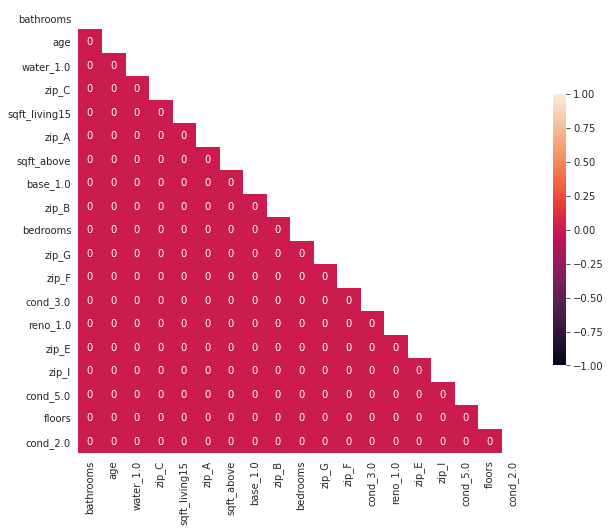

In [590]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

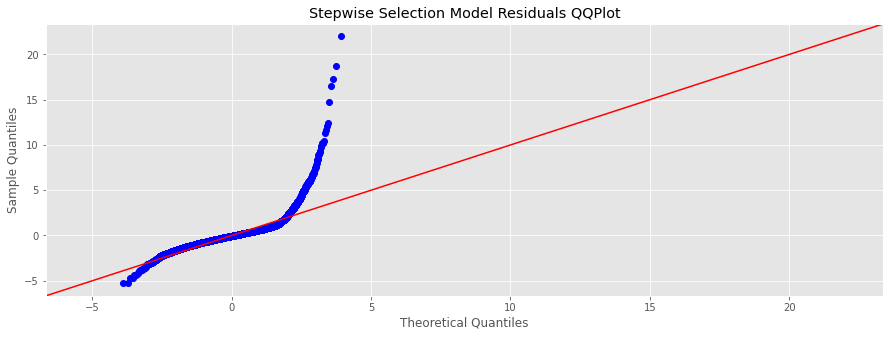

<Figure size 432x288 with 0 Axes>

In [591]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Stepwise Selection Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

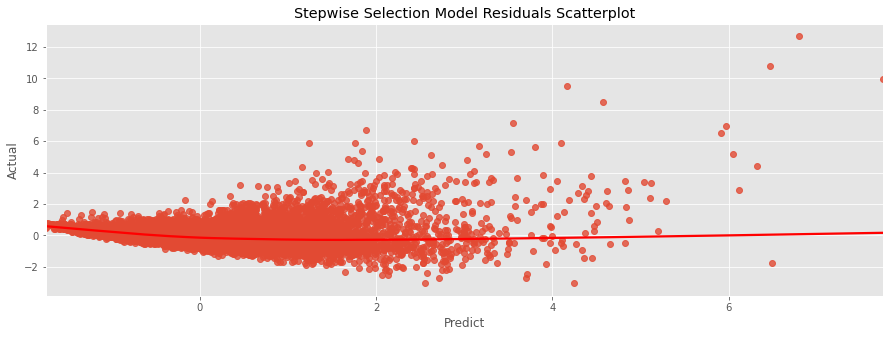

<Figure size 432x288 with 0 Axes>

In [592]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Stepwise Selection Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

**Recheck for overfitting: K-Fold Cross Validation**

In [593]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([0.66403173, 0.24464487, 0.21450189, 0.77799957, 0.32884724,
       0.14145199, 0.16126271, 0.30889938, 0.22139065, 0.22893337,
       0.28949137, 0.32087379, 0.35746123, 0.2776989 , 0.19162143,
       0.58810439, 0.35807486, 0.3801972 , 0.32911787, 0.38931994,
       0.21289214, 0.44979357, 0.36284449, 0.37369998, 0.17495214,
       0.47620763, 0.26055322, 0.40522182, 0.23218675, 0.24925798,
       0.33466799, 0.34778783, 0.17753693, 0.23926487, 0.43252492,
       0.54145409, 0.35796942, 0.25595297, 0.38070647, 0.2062803 ,
       0.35769936, 0.19975264, 0.41261375, 0.33648564, 0.69224497,
       0.43725257, 0.32475929, 0.22127143, 0.31703735, 0.25566005])

In [594]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

0.3360091389461825

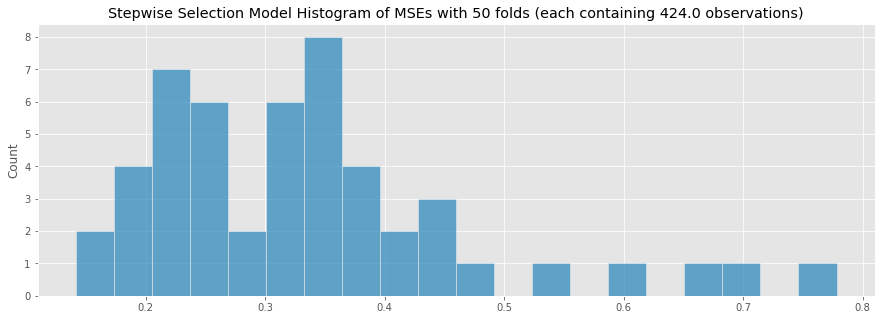

In [595]:
#visualize the cv_result

folds = 50
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Stepwise Selection Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Validate Model

In [596]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [597]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [598]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [599]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.3164361655406686
0.395227640275374


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

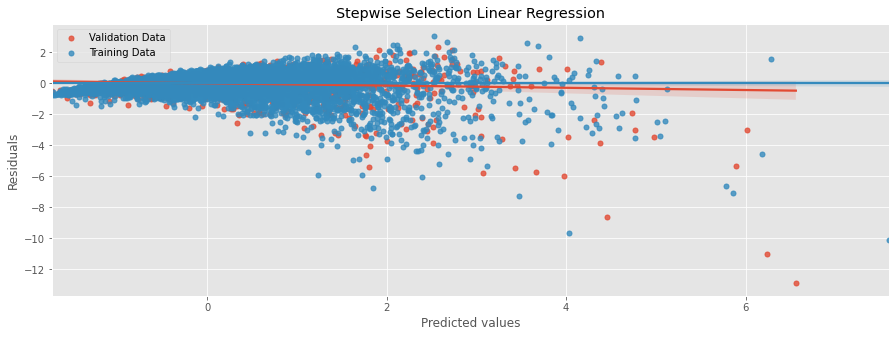

<Figure size 432x288 with 0 Axes>

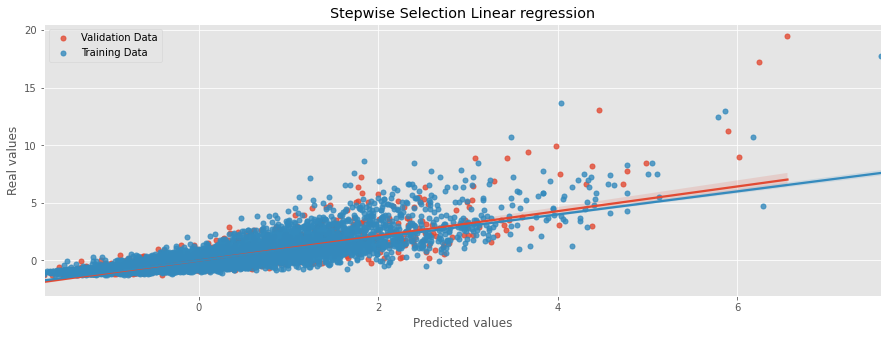

<Figure size 432x288 with 0 Axes>

In [600]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws = {'s': 25}, fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws = {'s': 25}, fit_reg = True, label = 'Training Data')


plt.title('Stepwise Selection Linear Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws = {'s': 25}, fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25}, fit_reg = True, label = 'Training Data')

plt.title('Stepwise Selection Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_predictions_regplot')

In [601]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

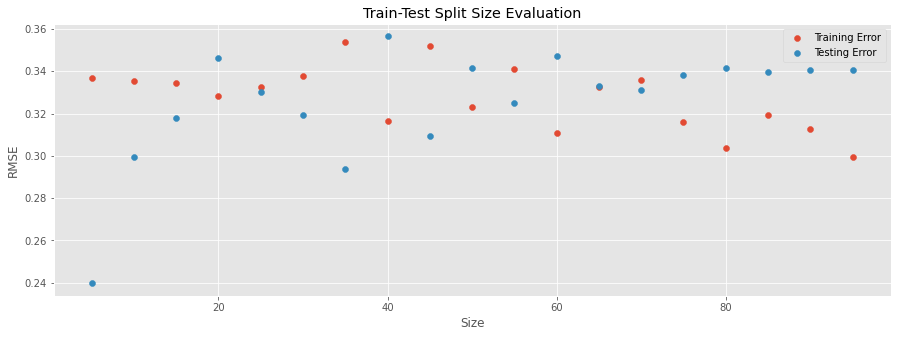

In [602]:
#evaluating the effect of train-test split size (learn.co)
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t_size / 100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label = 'Training Error')
plt.scatter(t_sizes, test_err, label = 'Testing Error')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_A_traintestsplit_scatterplot')

### Bias-Variance Tradeoff

In [603]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [604]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [605]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [606]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: 0.22888436995243763 
Train variance: 0.2432898924152152


### MODEL A OBSERVATIONS:

* The model' skewness and kurtosis have improved.
* Performance r2 = 0.66.
* The model does not have multicollinarity.
* The model failed normality assumption.
* The model failedhomoscadasticity assumption.
* The model is not overfitted.

In [607]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('model_A.pkl','wb'))

# MODEL B 
## REFINEMENT I: 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [608]:
clean.columns

Index(['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
       'sqft_lot15', 'bedrooms', 'bathrooms', 'floors', 'water_1.0',
       'base_1.0', 'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A',
       'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I',
       'zipcode', 'lat', 'long', 'price', 'sqft_above', 'sqft_lot',
       'sqft_living15', 'age'],
      dtype='object')

In [609]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [610]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [611]:
#excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [612]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

In [613]:
#apply function
result = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_B                          with p-value 2.01513e-234
Add  base_1.0                       with p-value 6.93761e-183
Add  zip_G                          with p-value 1.73556e-123
Add  bedrooms                       with p-value 2.48146e-67
Add  zip_F                          with p-value 9.25559e-21
Add  cond_3.0                       with p-value 5.63341e-20
Add  reno_1.0                       with p-value 5.59952e-18
Add  zip_E                          with p-value 3.741e-12
Add  zip_I                          with p-value 6.77894e-15
Add  cond_5.0                       with p-value 6.35801e-12
Add  sqft_lot     

In [614]:
#interecept is not included by default and should be added manually
X_in = X[result]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2091.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:05:11   Log-Likelihood:                -16195.
No. Observations:               21188   AIC:                         3.243e+04
Df Residuals:                   21167   BIC:                         3.260e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5935      0.024    -24.643      0.000      -0.641      -0.546
bathrooms         0.1650      0.009     19.392      0.000       0.148       0.182
age               0.1280      0.005     23.632      0.000       0.117       0.139
sqft_living15     0.2119      0.006     35.685      0.000       0.200       0.224
zip_A             0.7217      0.012     58.254      0.000       0.697       0.746
zip_C             0.7584      0.014     52.464      0.000       0.730       0.787
sqft_above        0.4574      0.008     60.897      0.000       0.443       0.472
water_1.0         2.0233      0.046     43.923      0.000       1.933       2.114
zip_B             0.4912      0.014     35.859      0.000       0.464       0.518
base_1.0          0.3035      0.009     32.369      0.000       0.285       0.322
zip_G             0.3658      0.016     23.161      0.000       0.335       0.397
bedrooms         -0.0878      0.005    -16.773      0.000      -0.098      -0.078
zip_F            -0.0766      0.016     -4.835      0.000      -0.108      -0.046
cond_3.0         -0.0807      0.009     -8.876      0.000      -0.099      -0.063
reno_1.0          0.1918      0.021      9.189      0.000       0.151       0.233
zip_E             0.1527      0.017      8.820      0.000       0.119       0.187
zip_I             0.1813      0.024      7.705      0.000       0.135       0.227
cond_5.0          0.0971      0.015      6.602      0.000       0.068       0.126
sqft_lot          0.0306      0.005      5.900      0.000       0.020       0.041
sqft_lot15     -7.79e-07   1.94e-07     -4.025      0.000   -1.16e-06      -4e-07
cond_2.0         -0.1587      0.042     -3.816      0.000      -0.240      -0.077
==============================================================================
Omnibus:                    13303.909   Durbin-Watson:                   1.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           347530.989
Skew:                           2.585   Prob(JB):                         0.00
Kurtosis:                      22.155   Cond. No.                     3.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [615]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result], y)

#predict yhat using our model
yhat = linreg.predict(X[result])
yhat

array([-1.01389426, -0.73824319, -0.29057426, ..., -0.63364009,
       -0.26609154, -0.52091067])

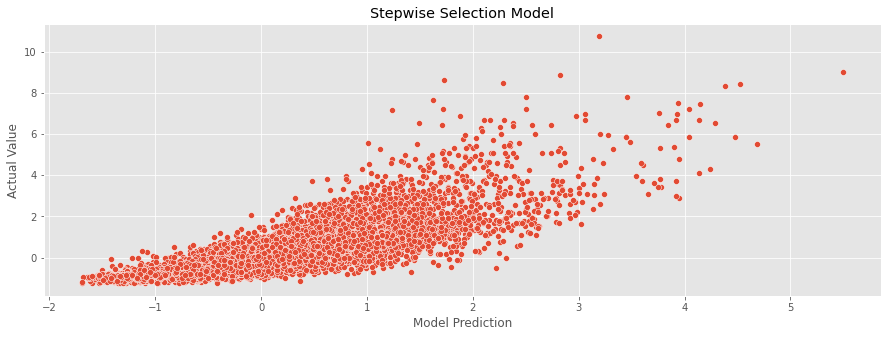

In [616]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.scatterplot(yhat, y)
plt.title('Stepwise Selection Model')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_scatterplot')

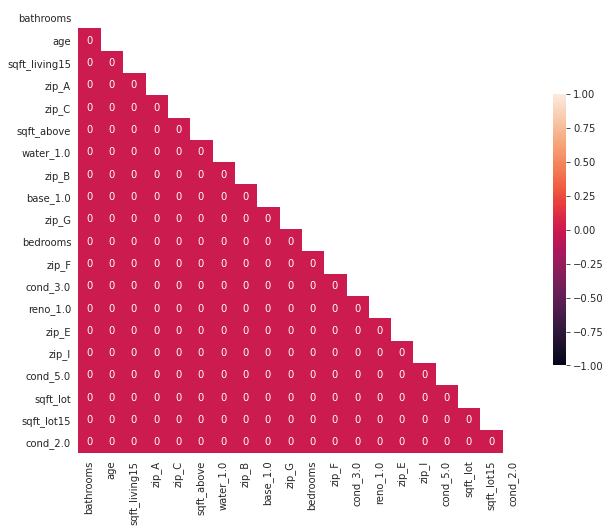

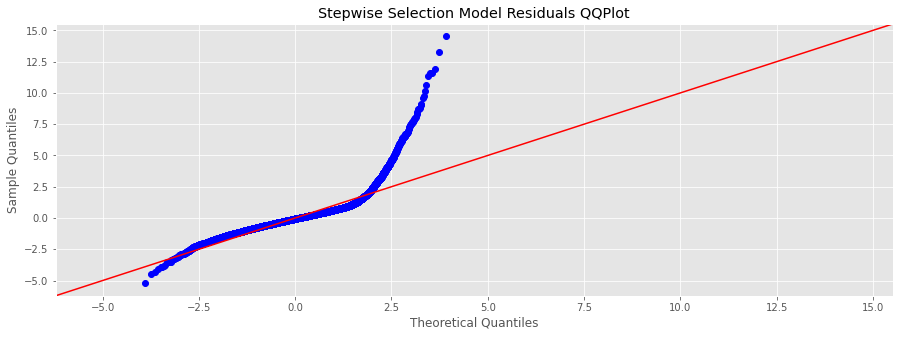

<Figure size 432x288 with 0 Axes>

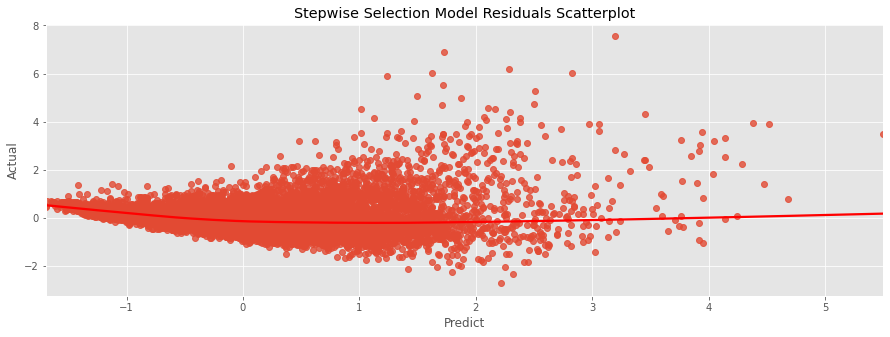

<Figure size 432x288 with 0 Axes>

In [617]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Stepwise Selection Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Stepwise Selection Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

In [618]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('model_B.pkl','wb'))

### MODEL B OBSERVATIONS:

* The model' skewness and kurtosis have improved.
* With outliers removed, performance still stays the same with r2 = 0.66.
* The model does not have multicollinarity.
* The model failed normality assumption.
* The model failedhomoscadasticity assumption.

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. 
For the next part of the project, we will use log-transformed features.